
### **Technical Assessment Report :** 
### In this notebook I present two methods used to automatically identify and count brain cells from brain scans.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import csv
from PIL import Image, ImageEnhance

## **Method 1 : Segmentation using OpenCV contour classification library** 
In this analysis, we utilized OpenCV for image processing, specifically leveraging its capabilities for color space conversion and contour detection. The method involves converting images to HSV color space for effective color segmentation, followed by identifying and visualizing virus-positive cells. <br>Note : The processing is done on the png format of the iitial image which was obtained using Fiji ImageJ.

### Step 1: Load and Preprocess the Image
 
We begin by loading the image in BGR format (default for OpenCV) and convert it to RGB for consistency in color processing across libraries.


In [2]:
image_path = 'Image_Oligodendrocytes_virus_neurons.png'
image = cv2.imread(image_path)

# Convert the image to RGB 
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Step 2: Convert to HSV Color Space for Color Segmentation
We convert the image to HSV to better isolate green (virus-positive cells), magenta (Oligodendrocytes) and blue (eurons). [1][2]

In [3]:
hsv_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

### Step 3: Define HSV Range for Virus-Positive Cells
Based on the image characteristics, we define a range in HSV to capture green regions. These values may require adjustment based on variations in the sample images.

In [4]:
# Virus-positive cells (green)
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])

# Oligodendrocytes (magenta)
lower_magenta = np.array([130, 40, 40])
upper_magenta = np.array([170, 255, 255])

# Neurons (blue)
lower_blue = np.array([100, 40, 40])
upper_blue = np.array([130, 255, 255])

### Step 4: Create a Mask and Apply it to the Image
We create masks for each cell type. 

In [5]:
virus_mask = cv2.inRange(hsv_image, lower_green, upper_green)
oligo_mask = cv2.inRange(hsv_image, lower_magenta, upper_magenta)
neuron_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

### Step 5: Detect Contours and Identify Cell Centroids
Contours in the mask represent detected cell regions. We loop through each contour, filter out small noise contours, and calculate the centroid for each virus-positive cell. The coordinates of detected cells are stored for further analysis. [3][4]

In [6]:
# Find contours in the mask (each contour represents a detected cell)
virus_contours, _ = cv2.findContours(virus_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

virus_oligo_coordinates = []
virus_neuron_coordinates = []
virus_other_coordinates = []

for contour in virus_contours:
    if cv2.contourArea(contour) > 50:  # Adjust the area threshold as needed
        # Get the centroid
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            
            # Create a mask for the individual virus cell to check overlap
            cell_mask = np.zeros(virus_mask.shape, dtype="uint8")
            cv2.drawContours(cell_mask, [contour], -1, 255, -1)

            # Check overlap with oligodendrocytes 
            oligo_overlap = cv2.bitwise_and(cell_mask, oligo_mask)
            neuron_overlap = cv2.bitwise_and(cell_mask, neuron_mask)

            # Determine which cell type it overlaps with
            if cv2.countNonZero(oligo_overlap) > 0:
                virus_oligo_coordinates.append((cX, cY))
                color = (255, 0, 255)  # Magenta for oligo-virus
            elif cv2.countNonZero(neuron_overlap) > 0:
                virus_neuron_coordinates.append((cX, cY))
                color = (0, 0, 255)  # Blue for neuron-virus
            else:
                virus_other_coordinates.append((cX, cY))
                color = (0, 255, 0)  # Green for unclassified virus-positive

            # Draw the detected cell with classification color
            cv2.circle(image_rgb, (cX, cY), 5, color, -1)

### Step 6: Display Results and Plot Cell Coordinates
The resulting image highlights the detected virus-positive cells with blue circles at each centroid. Additionally, we plot the cell coordinates on a scatter plot to visualize spatial distribution.


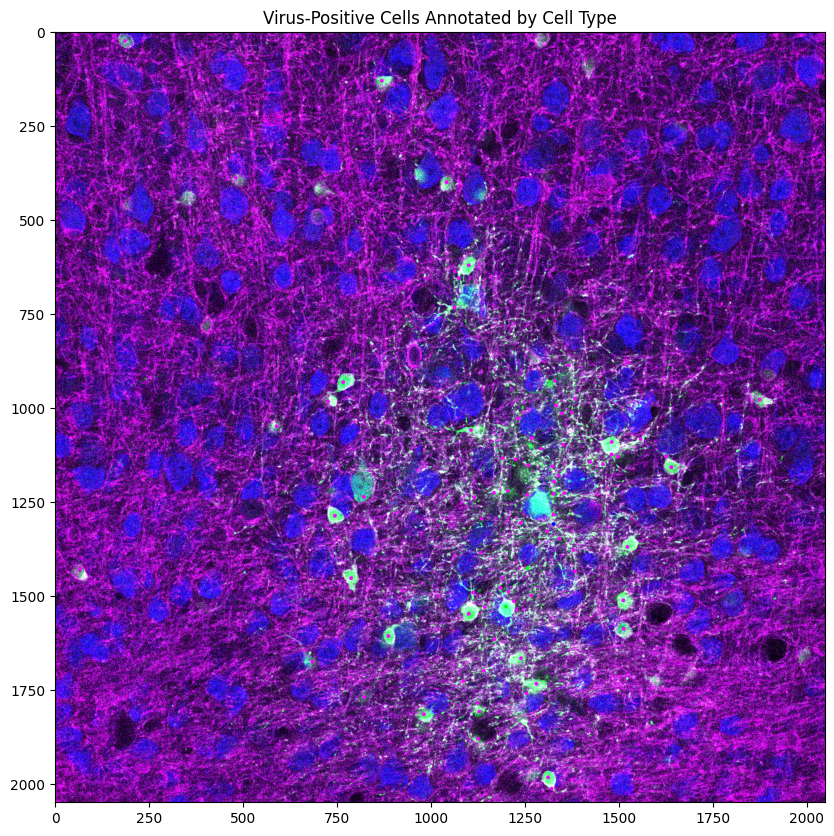

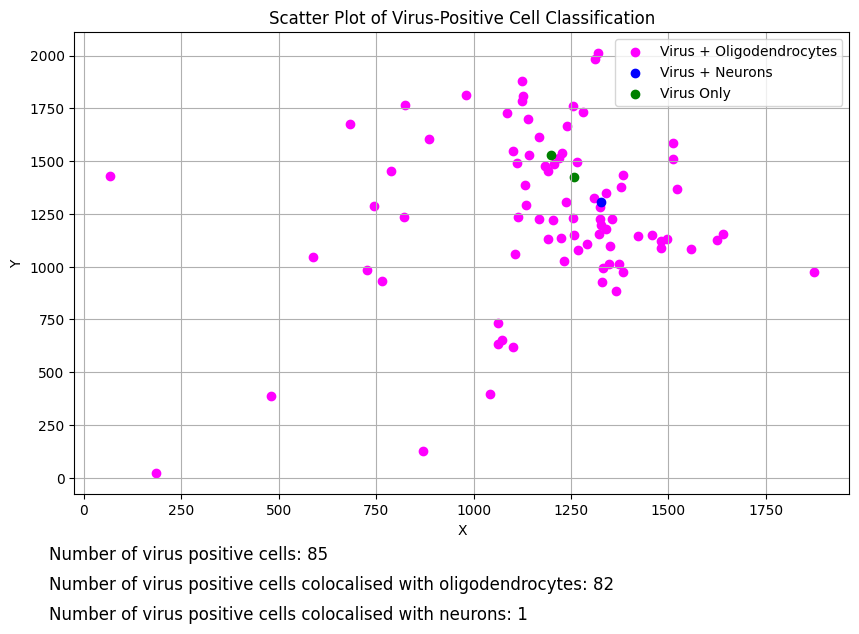

In [7]:

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title("Virus-Positive Cells Annotated by Cell Type")
plt.show()

# Plot the scatter plot for each category
plt.figure(figsize=(10, 6))
if virus_oligo_coordinates:
    x_oligo, y_oligo = zip(*virus_oligo_coordinates)
    plt.scatter(x_oligo, y_oligo, color='magenta', label='Virus + Oligodendrocytes')
if virus_neuron_coordinates:
    x_neuron, y_neuron = zip(*virus_neuron_coordinates)
    plt.scatter(x_neuron, y_neuron, color='blue', label='Virus + Neurons')
if virus_other_coordinates:
    x_other, y_other = zip(*virus_other_coordinates)
    plt.scatter(x_other, y_other, color='green', label='Virus Only')

# Add text annotations for the number of cells in each category
total_vp_cells = len(virus_oligo_coordinates) + len(virus_neuron_coordinates) + len(virus_other_coordinates)
total_vp_oligo = len(virus_oligo_coordinates)
total_vp_neuron = len(virus_neuron_coordinates)
plt.figtext(0.1, -0, f'Number of virus positive cells: {total_vp_cells}', ha='left', fontsize=12)
plt.figtext(0.1, -0.05, f'Number of virus positive cells colocalised with oligodendrocytes: {total_vp_oligo}', ha='left', fontsize=12)
plt.figtext(0.1, -0.1, f'Number of virus positive cells colocalised with neurons: {total_vp_neuron}', ha='left', fontsize=12)

plt.title("Scatter Plot of Virus-Positive Cell Classification")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

### **Observations:**
__Two main observations__ :
1. Cells with clear topological borders are mostly correctly classified.
2. This method seems overly sensitive since it is classifying bright points as cells, implying that this program is prone to amelioration and precision increase.

__Insights for method improvement__ 
1. Increasing contour threshhold.
2. Comparing with the validation file by creating a similar file for the results and implementing discrepency analysis. Makes room for supervised mearning methods. One idea is to also split the counting file into a training and a test set, but since data quantity here is not very important and separation is not linear, it could be challenging to train a model. Similar proposals will be discussed in the second method.

Creating an output file for the result, using hte same format as counting.csv

In [8]:
updated_counting = pd.DataFrame(columns=['VIRUS_ID', 'X', 'Y', 'OL', 'NEURON', 'UNKNOWN'])
virus_id = 1
rows = []
for (cX, cY) in virus_oligo_coordinates:
    rows.append({'VIRUS_ID': virus_id, 'X': cX, 'Y': cY, 'OL': 1, 'NEURON': np.nan, 'UNKNOWN': np.nan})
    virus_id += 1
for (cX, cY) in virus_neuron_coordinates:
    rows.append({'VIRUS_ID': virus_id, 'X': cX, 'Y': cY, 'OL': np.nan, 'NEURON': 1, 'UNKNOWN': np.nan})
    virus_id += 1
for (cX, cY) in virus_other_coordinates:
    rows.append({'VIRUS_ID': virus_id, 'X': cX, 'Y': cY, 'OL': np.nan, 'NEURON': np.nan, 'UNKNOWN': 1})
    virus_id += 1
updated_counting = pd.DataFrame(rows)
updated_counting['OL'] = updated_counting['OL'].astype('Int64')
updated_counting['NEURON'] = updated_counting['NEURON'].astype('Int64')
updated_counting['UNKNOWN'] = updated_counting['UNKNOWN'].astype('Int64')
updated_counting.to_csv('updated_counting.csv', index=False)

Increasing the contour threshhold

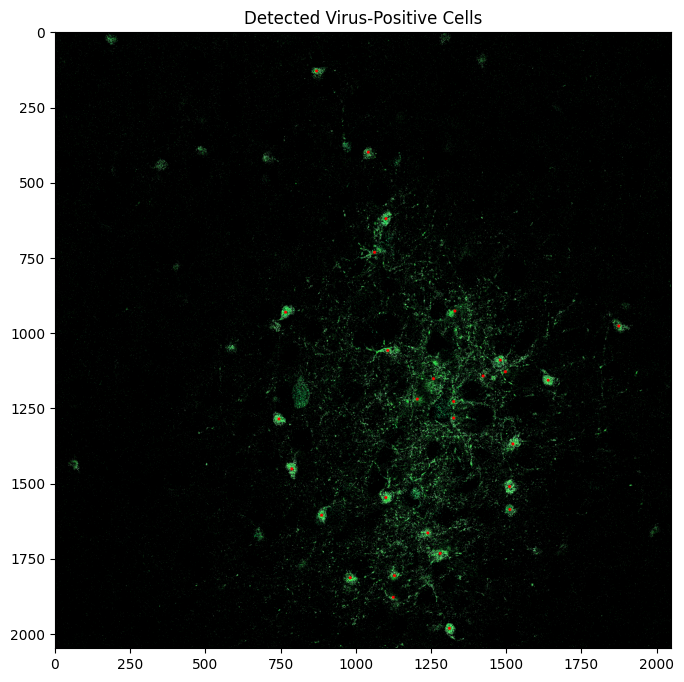

In [9]:
image_path = 'Image_Oligodendrocytes_virus_neurons.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# Focusing on the virus-positive cells (green) only for this part
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])
mask = cv2.inRange(hsv_image, lower_green, upper_green)
result = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cell_coordinates = []

for contour in contours:
    if cv2.contourArea(contour) > 200:  # Trying 200 instead of 50 
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            cell_coordinates.append((cX, cY))
            cv2.circle(result, (cX, cY), 5, (255, 0, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(result) # Display the image with detected virus-positive cells with red dots in the center
plt.title("Detected Virus-Positive Cells")
plt.show()



## **Method 2 : Convolutional Neural Network (CNN) Approach**

In this method, we use a CNN model to classify the cells in question (virus-positive cells, oligodendrocytes, and neurons). CNNs are powerful for image classification and segmentation tasks, as they can learn complex patterns and features from the data.

This section includes:
1. **Data Preprocessing**: Load and preprocess images suitable for CNN.
2. **CNN Model Design**: A basic CNN architecture tailored for cell classification.
3. **Training and Evaluation**: Train the model if labeled data is available; otherwise, use a pre-trained model.
4. **Prediction**: Predict cell types on new images and visualize the results.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

 **Data Preprocessing**	
1.	Image Resizing: Ensures all images are the same size (128x128) for consistent input to the model.
2.	Convert to Tensor: Transforms the image into a tensor format compatible with PyTorch.
3.	Normalization: Scales pixel values to a range centered around 0 with a mean of 0.5 and standard deviation of 0.5, which stabilizes training and speeds up convergence.
4.	Add Batch Dimension: Adds a batch dimension to allow single images to be used in batch processing during model inference.

In [11]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),           
    transforms.Normalize((0.5,), (0.5,))  
])

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0) 

image_path = 'Image_Oligodendrocytes_virus_neurons.png' 
input_image = load_and_preprocess_image(image_path)

**CNN Architecture**
1.	Convolutional Layer 1: The 3x3 kernel with padding captures fine details in the cell images, such as edges and small textures characteristic of cell boundaries and nuclei.
2. Convolutional Layer 2: Expanding to 32 filters at this layer allows the model to capture more complex patterns, such as cell shape. Padding ensures that cell features near the edges aren’t missed.
3. Fully Connected Layers: The flattened feature map is reduced to 128 neurons, creating a high-level representation of each cell type.
4. ReLU Activation Function: ReLU is applied to each layer to amplify feature differences specific to each cell type, like brightness variations in virus-positive cells.
5.	Max Pooling: Reduces the spatial dimensions after each convolutional layer, condensing information and focusing on the most distinctive features (e.g., nuclei and texture clusters)
6.	Cross-Entropy Loss: Its probabilistic output aligns well with multi-class cell-type classification, encouraging the model to strongly favor the correct cell type in ambiguous regions.

In [12]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)  # Assuming 3 classes: virus-positive, oligodendrocytes, neurons

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### **Contribution to the Task:**

This section was intended to further refine the classification and counting of virus-positive cells by increasing the contour threshold. By doing so, the goal was to reduce the sensitivity of the detection algorithm, thereby minimizing the classification of bright points as cells and improving the precision of the method. This refinement is crucial for ensuring that the identified cells are indeed virus-positive and not artifacts or noise, as we have seen in the first method. This would enhance the reliability and accuracy of the overall cell counting and classification process which is especially crucial for similar applications in the medical field. 

### References

1. OpenCV Documentation on Color Spaces. [OpenCV Documentation - Changing Colorspaces](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html)
2. Gonzalez, R. C., & Woods, R. E. (2008). *Digital Image Processing* (3rd ed.). Pearson Prentice Hall.
3. Al-Amri, S. S., Kalyankar, N. V., & Khamitkar, S. D. (2010). Image segmentation by using threshold techniques. *Journal of Computing*, 2(5), 83-86. Available at: [Journal of Computing](http://www.journalofcomputing.org)
4. Das Gupta A, Asan L, John J, Beretta C, Kuner T, Knabbe J. [Accurate classification of major brain cell types using in vivo imaging and neural network processing](https://pmc.ncbi.nlm.nih.gov/articles/PMC10689024/). PLoS Biol. 2023 Nov 9;21(11):e3002357. doi: 10.1371/journal.pbio.3002357. PMID: 37943858; PMCID: PMC10689024.
5. OpenAI. (2024). [ChatGPT](https://www.openai.com/chatgpt) (GPT-3.5) [Language model] - used to help with syntax and functions of the OpenCV library since I am not very experimented with it - in addition to the help from the original documentation

### Appendix

Checking counting.csv scatter for insight

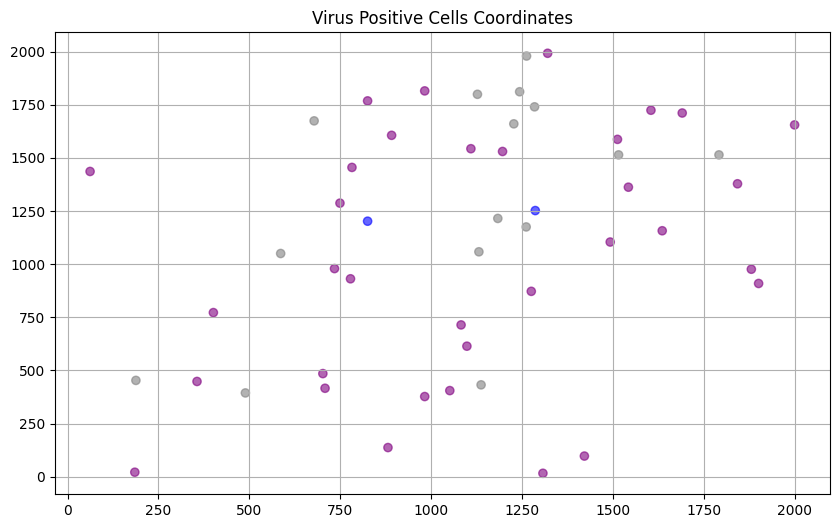

In [13]:
data = pd.read_csv('counting.csv')
colors = data.apply(lambda row: 
                    'purple' if pd.notna(row['OL']) else 
                    'blue' if pd.notna(row['NEURON']) else 
                    'gray' if pd.notna(row['UNKNOWN']) else 'black', axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(data['X'], data['Y'], c=colors, alpha=0.6)
plt.title('Virus Positive Cells Coordinates')
plt.grid(True)
plt.show()

Attempt at directly utilizing .tif image and visualization of the different channels included in the image.

In [14]:
image = Image.open("Image_Oligodendrocytes_virus_neurons.tif")
try:
    while True:
        image.seek(image.tell())
        image.show()  
        image.seek(image.tell() + 1)
except EOFError:
    pass